In [1]:
import pandas as pd

In [2]:
import sqlite3

conn = sqlite3.connect("instacart.db")

departments = pd.read_sql("SELECT * FROM departments", conn)
aisles = pd.read_sql("SELECT * FROM aisles", conn)
products = pd.read_sql("SELECT * FROM products", conn)
orders = pd.read_sql("SELECT * FROM orders", conn)
order_products_prior = pd.read_sql("SELECT * FROM order_products_prior", conn)
order_products_train = pd.read_sql("SELECT * FROM order_products_train", conn)


In [3]:
def resumen(df, nombre):
    print(f"\n📄 {nombre.upper()}")
    print("-" * 40)
    print("Forma:", df.shape)
    print("Columnas con nulos:\n", df.isnull().sum())
    print("Tipos de datos:\n", df.dtypes)

# Revisión
resumen(departments, "departments")
resumen(aisles, "aisles")
resumen(products, "products")
resumen(orders, "orders")
resumen(order_products_prior, "order_products_prior")
resumen(order_products_train, "order_products_train")



📄 DEPARTMENTS
----------------------------------------
Forma: (21, 2)
Columnas con nulos:
 department_id    0
department       0
dtype: int64
Tipos de datos:
 department_id     int64
department       object
dtype: object

📄 AISLES
----------------------------------------
Forma: (134, 2)
Columnas con nulos:
 aisle_id    0
aisle       0
dtype: int64
Tipos de datos:
 aisle_id     int64
aisle       object
dtype: object

📄 PRODUCTS
----------------------------------------
Forma: (49688, 4)
Columnas con nulos:
 product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64
Tipos de datos:
 product_id        int64
product_name     object
aisle_id          int64
department_id     int64
dtype: object

📄 ORDERS
----------------------------------------
Forma: (3421083, 7)
Columnas con nulos:
 order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_d

In [4]:
top_productos = order_products_prior['product_id'].value_counts().head(10)
print("\nTop 10 productos más vendidos (por ID):\n", top_productos)

# Opcional: unir con el nombre del producto
top_productos_df = pd.DataFrame({'product_id': top_productos.index, 'count': top_productos.values})
top_productos_df = top_productos_df.merge(products[['product_id', 'product_name']], on='product_id')
print("\nTop 10 productos más vendidos (con nombre):\n", top_productos_df)



Top 10 productos más vendidos (por ID):
 product_id
24852    472565
13176    379450
21137    264683
21903    241921
47209    213584
47766    176815
47626    152657
16797    142951
26209    140627
27845    137905
Name: count, dtype: int64

Top 10 productos más vendidos (con nombre):
    product_id   count            product_name
0       24852  472565                  Banana
1       13176  379450  Bag of Organic Bananas
2       21137  264683    Organic Strawberries
3       21903  241921    Organic Baby Spinach
4       47209  213584    Organic Hass Avocado
5       47766  176815         Organic Avocado
6       47626  152657             Large Lemon
7       16797  142951            Strawberries
8       26209  140627                   Limes
9       27845  137905      Organic Whole Milk


In [5]:
n_usuarios = orders['user_id'].nunique()
print(f"\n👥 Número de usuarios únicos: {n_usuarios}")



👥 Número de usuarios únicos: 206209


In [6]:
no_reordenados = order_products_prior[order_products_prior['reordered'] == 0]
nunca_reordenados = no_reordenados['product_id'].nunique()
print(f"\n🛒 Productos que no fueron reordenados: {nunca_reordenados}")



🛒 Productos que no fueron reordenados: 49677


In [7]:
# 1. Forma de la tabla
print("🔢 Dimensiones:", orders.shape)

# 2. Valores nulos por columna
print("\n🕳️ Valores nulos:")
print(orders.isnull().sum())

# 3. Tipos de datos
print("\n🧬 Tipos de datos:")
print(orders.dtypes)

# 4. Vista previa
print("\n👀 Primeras filas:")
print(orders.head())

🔢 Dimensiones: (3421083, 7)

🕳️ Valores nulos:
order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

🧬 Tipos de datos:
order_id                    int64
user_id                     int64
eval_set                   object
order_number                int64
order_dow                   int64
order_hour_of_day           int64
days_since_prior_order    float64
dtype: object

👀 Primeras filas:
   order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0         1   112108    train             4          4                 10   
1         2   202279    prior             3          5                  9   
2         3   205970    prior            16          5                 17   
3         4   178520    prior            36          1                  9   
4         5   156122    prior     

In [8]:
primeros_pedidos = orders[orders['order_number'] == 1]
print("¿Coinciden los nulos con el primer pedido de cada usuario?",
      (primeros_pedidos['days_since_prior_order'].isnull().all()))


¿Coinciden los nulos con el primer pedido de cada usuario? True


In [9]:

# Copia del dataframe original (opcional, para no alterar el original directamente)
orders_cleaned = orders.copy()

# 1. Identificar usuarios que tienen tanto NaN como 0
usuarios_con_nan_y_cero = orders_cleaned.groupby('user_id')['days_since_prior_order'].apply(
    lambda x: x.isnull().any() and (x == 0).any()
)
usuarios_a_eliminar_nan = usuarios_con_nan_y_cero[usuarios_con_nan_y_cero].index

# 2. Eliminar los registros con NaN para esos usuarios
orders_cleaned = orders_cleaned[~(
    (orders_cleaned['user_id'].isin(usuarios_a_eliminar_nan)) &
    (orders_cleaned['days_since_prior_order'].isnull())
)]

# 3. Para el resto (usuarios con solo NaN), rellenar con 0
orders_cleaned['days_since_prior_order'].fillna(0, inplace=True)


/tmp/ipykernel_21712/778786836.py:17: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders_cleaned['days_since_prior_order'].fillna(0, inplace=True)


In [10]:

# 🧼 Crear una copia para no modificar el original
orders_cleaned = orders.copy()

# 🔍 Paso 1: Identificar usuarios con tanto NaN como 0
usuarios_con_nan_y_cero = orders_cleaned.groupby('user_id')['days_since_prior_order'].apply(
    lambda x: x.isnull().any() and (x == 0).any()
)
usuarios_a_eliminar_nan = usuarios_con_nan_y_cero[usuarios_con_nan_y_cero].index

# ✂️ Paso 2: Eliminar registros con NaN si el usuario ya tiene un 0
antes_de_eliminar = len(orders_cleaned)
orders_cleaned = orders_cleaned[~(
    (orders_cleaned['user_id'].isin(usuarios_a_eliminar_nan)) &
    (orders_cleaned['days_since_prior_order'].isnull())
)]
despues_de_eliminar = len(orders_cleaned)

# 🧩 Paso 3: Rellenar los NaN restantes con 0
nulos_antes = orders_cleaned['days_since_prior_order'].isnull().sum()
orders_cleaned['days_since_prior_order'].fillna(0, inplace=True)
nulos_despues = orders_cleaned['days_since_prior_order'].isnull().sum()

# ✅ Paso 4: Comprobaciones
print("📋 Comprobación de limpieza:\n")
print(f"📉 Registros antes de limpiar: {len(orders)}")
print(f"📈 Registros después de limpiar: {len(orders_cleaned)}")
print(f"🧹 Registros eliminados: {antes_de_eliminar - despues_de_eliminar}")
print(f"❓ Nulos antes del fill: {nulos_antes}")
print(f"✅ Nulos después del fill: {nulos_despues}")

# 🔎 Paso 5: Mostrar usuarios que ahora tienen 0 (antes tenían solo NaN)
usuarios_con_cero = orders_cleaned[orders_cleaned['days_since_prior_order'] == 0]['user_id'].unique()

print("\n👥 Ejemplos de usuarios que ahora tienen 0 como primer valor:")
print(usuarios_con_cero[:10])

# 🔍 Paso 6: Visualizar un caso concreto (puedes cambiar el ID)
ejemplo_id = usuarios_con_cero[0]
print(f"\n🧾 Ejemplo de registros del usuario {ejemplo_id} (antes):")
print(orders[orders['user_id'] == ejemplo_id])

print(f"\n🧾 Ejemplo de registros del usuario {ejemplo_id} (después):")
print(orders_cleaned[orders_cleaned['user_id'] == ejemplo_id])


📋 Comprobación de limpieza:

📉 Registros antes de limpiar: 3421083
📈 Registros después de limpiar: 3387866
🧹 Registros eliminados: 33217
❓ Nulos antes del fill: 172992
✅ Nulos después del fill: 0

👥 Ejemplos de usuarios que ahora tienen 0 como primer valor:
[182912 193635 202527  37913 152590 106387  62781  73241  91891 119087]

🧾 Ejemplo de registros del usuario 182912 (antes):
         order_id  user_id eval_set  order_number  order_dow  \
19             20   182912    prior             1          6   
146547     146548   182912    prior            22          4   
188487     188488   182912    prior            16          6   
438485     438486   182912    prior            18          0   
473695     473696   182912    prior            21          1   
496568     496569   182912    prior             5          5   
895221     895222   182912    prior             2          1   
1421343   1421344   182912    train            23          2   
1501743   1501744   182912    prior       

/tmp/ipykernel_21712/2320354108.py:20: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  orders_cleaned['days_since_prior_order'].fillna(0, inplace=True)


In [11]:
# Mostrar forma (filas, columnas) de cada tabla
print("📦 Resumen general de las tablas:\n")
for name, df in [
    ("departments", departments),
    ("aisles", aisles),
    ("products", products),
    ("orders", orders),
    ("order_products_prior", order_products_prior),
    ("order_products_train", order_products_train),
]:
    print(f"▶️ {name}: {df.shape[0]} filas × {df.shape[1]} columnas")

📦 Resumen general de las tablas:

▶️ departments: 21 filas × 2 columnas
▶️ aisles: 134 filas × 2 columnas
▶️ products: 49688 filas × 4 columnas
▶️ orders: 3421083 filas × 7 columnas
▶️ order_products_prior: 32434489 filas × 4 columnas
▶️ order_products_train: 1384617 filas × 4 columnas


DEPARTMENTS

In [12]:
print("🟩 Tabla: departments\n")
print(departments.info())
print("\nValores únicos:", departments.nunique())
print("\nDatos únicos:\n", departments.drop_duplicates())


🟩 Tabla: departments

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21 entries, 0 to 20
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   department_id  21 non-null     int64 
 1   department     21 non-null     object
dtypes: int64(1), object(1)
memory usage: 468.0+ bytes
None

Valores únicos: department_id    21
department       21
dtype: int64

Datos únicos:
     department_id       department
0               1           frozen
1               2            other
2               3           bakery
3               4          produce
4               5          alcohol
5               6    international
6               7        beverages
7               8             pets
8               9  dry goods pasta
9              10             bulk
10             11    personal care
11             12     meat seafood
12             13           pantry
13             14        breakfast
14             15     canned good

In [13]:
print("🟦 Tabla: aisles\n")
print(aisles.info())
print("\nValores únicos:", aisles.nunique())
print("\nDatos únicos:\n", aisles.drop_duplicates())


🟦 Tabla: aisles

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 134 entries, 0 to 133
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   aisle_id  134 non-null    int64 
 1   aisle     134 non-null    object
dtypes: int64(1), object(1)
memory usage: 2.2+ KB
None

Valores únicos: aisle_id    134
aisle       134
dtype: int64

Datos únicos:
      aisle_id                       aisle
0           1       prepared soups salads
1           2           specialty cheeses
2           3         energy granola bars
3           4               instant foods
4           5  marinades meat preparation
..        ...                         ...
129       130    hot cereal pancake mixes
130       131                   dry pasta
131       132                      beauty
132       133  muscles joints pain relief
133       134  specialty wines champagnes

[134 rows x 2 columns]


In [14]:
print("🟨 Tabla: products\n")
print(products.info())
print("\n🔍 Nulos:\n", products.isnull().sum())
print("\n📊 Estadísticas:\n", products.describe())
print("\n📦 Productos por departamento (top 10):")
print(products['department_id'].value_counts().head(10))
print("\n🛒 Productos por pasillo (top 10):")
print(products['aisle_id'].value_counts().head(10))


🟨 Tabla: products

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49688 entries, 0 to 49687
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   product_id     49688 non-null  int64 
 1   product_name   49688 non-null  object
 2   aisle_id       49688 non-null  int64 
 3   department_id  49688 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 1.5+ MB
None

🔍 Nulos:
 product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

📊 Estadísticas:
          product_id      aisle_id  department_id
count  49688.000000  49688.000000   49688.000000
mean   24844.500000     67.769582      11.728687
std    14343.834425     38.316162       5.850410
min        1.000000      1.000000       1.000000
25%    12422.750000     35.000000       7.000000
50%    24844.500000     69.000000      13.000000
75%    37266.250000    100.000000      17.000000
max    49688.000000    134.000000      21.000000



🟥 Tabla: orders

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
 #   Column                  Dtype  
---  ------                  -----  
 0   order_id                int64  
 1   user_id                 int64  
 2   eval_set                object 
 3   order_number            int64  
 4   order_dow               int64  
 5   order_hour_of_day       int64  
 6   days_since_prior_order  float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB
None

🔍 Nulos:
 order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

📊 Estadísticas:
            order_id       user_id  order_number     order_dow  \
count  3.421083e+06  3.421083e+06  3.421083e+06  3.421083e+06   
mean   1.710542e+06  1.029782e+05  1.715486e+01  2.776219e+00   
s

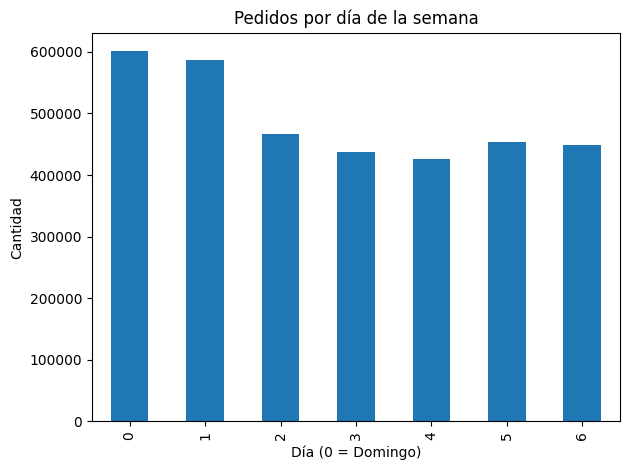

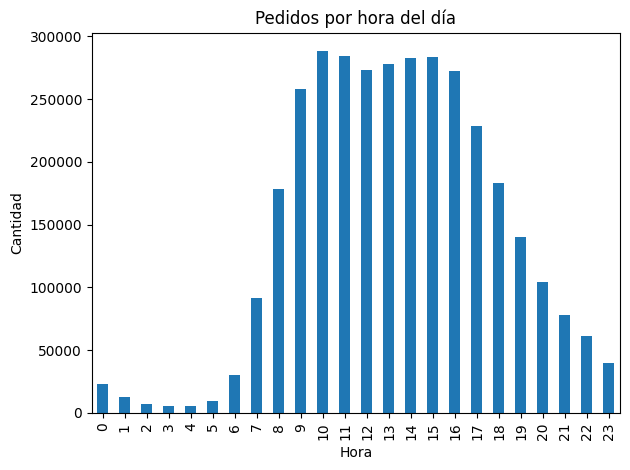

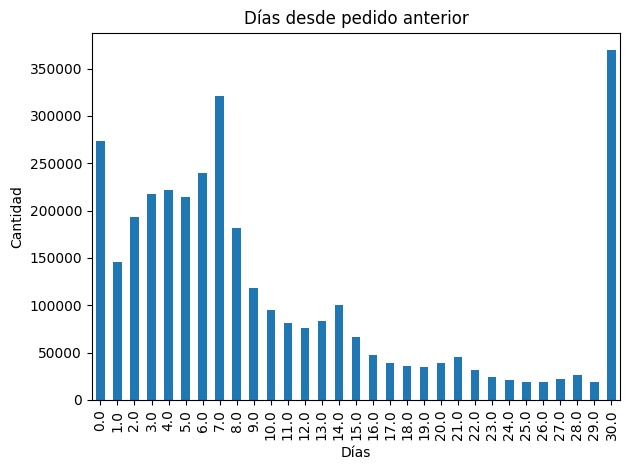

In [16]:
print("🟥 Tabla: orders\n")
print(orders.info())
print("\n🔍 Nulos:\n", orders.isnull().sum())
print("\n📊 Estadísticas:\n", orders.describe())

# Distribuciones
import matplotlib.pyplot as plt

# Día de la semana
orders['order_dow'].value_counts().sort_index().plot(kind='bar', title="Pedidos por día de la semana")
plt.xlabel("Día (0 = Domingo)")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

# Hora del día
orders['order_hour_of_day'].value_counts().sort_index().plot(kind='bar', title="Pedidos por hora del día")
plt.xlabel("Hora")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()

# Días desde el pedido anterior
orders['days_since_prior_order'].fillna(0).value_counts().sort_index().plot(kind='bar', title="Días desde pedido anterior")
plt.xlabel("Días")
plt.ylabel("Cantidad")
plt.tight_layout()
plt.show()


🟧 Tabla: order_products_prior

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
 #   Column             Dtype
---  ------             -----
 0   order_id           int64
 1   product_id         int64
 2   add_to_cart_order  int64
 3   reordered          int64
dtypes: int64(4)
memory usage: 989.8 MB
None

🔍 Nulos:
 order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

📊 Estadísticas:
            order_id    product_id  add_to_cart_order     reordered
count  3.243449e+07  3.243449e+07       3.243449e+07  3.243449e+07
mean   1.710749e+06  2.557634e+04       8.351076e+00  5.896975e-01
std    9.873007e+05  1.409669e+04       7.126671e+00  4.918886e-01
min    2.000000e+00  1.000000e+00       1.000000e+00  0.000000e+00
25%    8.559430e+05  1.353000e+04       3.000000e+00  0.000000e+00
50%    1.711048e+06  2.525600e+04       6.000000e+00  1.000000e+00
75%    2.565514e+06  3.7935

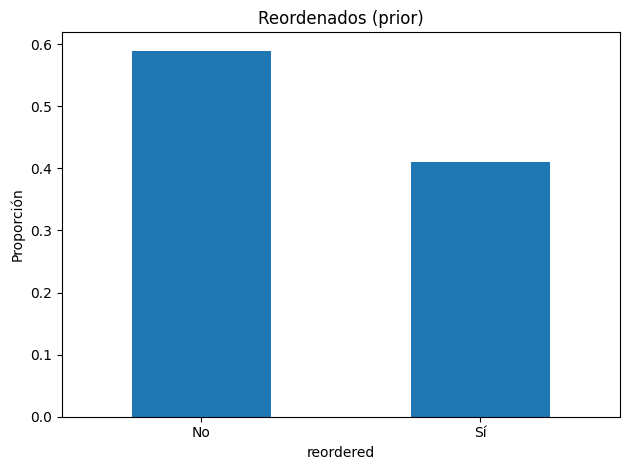

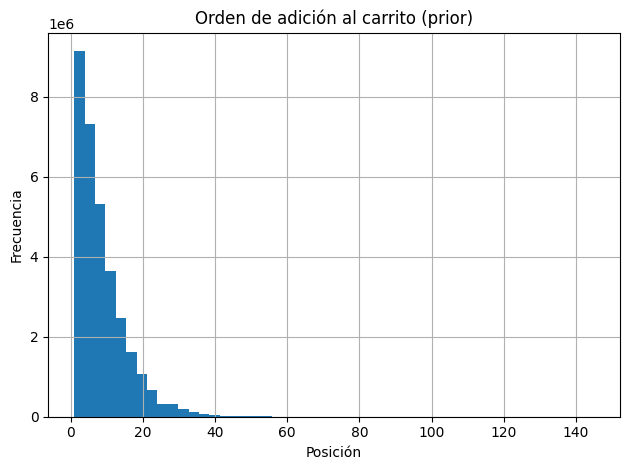

In [18]:
print("🟧 Tabla: order_products_prior\n")
print(order_products_prior.info())
print("\n🔍 Nulos:\n", order_products_prior.isnull().sum())
print("\n📊 Estadísticas:\n", order_products_prior.describe())

# Reordenados
order_products_prior['reordered'].value_counts(normalize=True).plot(kind='bar', title="Reordenados (prior)")
plt.xticks([0,1], ['No', 'Sí'], rotation=0)
plt.ylabel("Proporción")
plt.tight_layout()
plt.show()

# Posición en el carrito
order_products_prior['add_to_cart_order'].hist(bins=50)
plt.title("Orden de adición al carrito (prior)")
plt.xlabel("Posición")
plt.ylabel("Frecuencia")
plt.tight_layout()
plt.show()


🟪 Tabla: order_products_train

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1384617 entries, 0 to 1384616
Data columns (total 4 columns):
 #   Column             Non-Null Count    Dtype
---  ------             --------------    -----
 0   order_id           1384617 non-null  int64
 1   product_id         1384617 non-null  int64
 2   add_to_cart_order  1384617 non-null  int64
 3   reordered          1384617 non-null  int64
dtypes: int64(4)
memory usage: 42.3 MB
None

🔍 Nulos:
 order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

📊 Estadísticas:
            order_id    product_id  add_to_cart_order     reordered
count  1.384617e+06  1.384617e+06       1.384617e+06  1.384617e+06
mean   1.706298e+06  2.555624e+04       8.758044e+00  5.985944e-01
std    9.897326e+05  1.412127e+04       7.423936e+00  4.901829e-01
min    1.000000e+00  1.000000e+00       1.000000e+00  0.000000e+00
25%    8.433700e+05  1.338000e+04       3.000000e+00  0.

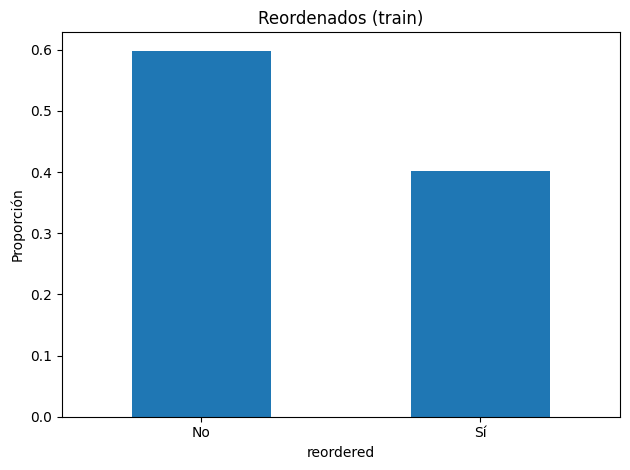

In [21]:
print("🟪 Tabla: order_products_train\n")
print(order_products_train.info())
print("\n🔍 Nulos:\n", order_products_train.isnull().sum())
print("\n📊 Estadísticas:\n", order_products_train.describe())

# Reordenados
order_products_train['reordered'].value_counts(normalize=True).plot(kind='bar', title="Reordenados (train)")
plt.xticks([0,1], ['No', 'Sí'], rotation=0)
plt.ylabel("Proporción")
plt.tight_layout()
plt.show()


In [22]:
# 1️⃣ Total de pedidos por usuario
pedidos = orders.groupby('user_id').agg({
    'order_number': 'max',
    'days_since_prior_order': 'mean'
}).rename(columns={
    'order_number': 'n_pedidos',
    'days_since_prior_order': 'dias_medios_entre_pedidos'
})

# 2️⃣ Número de productos por usuario
productos = order_products_prior.merge(orders[['order_id', 'user_id']], on='order_id')
productos_por_usuario = productos.groupby('user_id').agg({
    'product_id': 'count',
    'reordered': 'mean'
}).rename(columns={
    'product_id': 'total_productos_comprados',
    'reordered': 'porcentaje_reordenados'
})

# 3️⃣ Número medio de productos por pedido
productos_por_pedido = productos.groupby(['user_id', 'order_id']).size().groupby('user_id').mean().rename('productos_por_pedido')

# 4️⃣ Asignar las islas en las que ha comprado cada usuario
productos_con_aisles = productos.merge(products[['product_id', 'aisle_id']], on='product_id')

# Crear variables dummies para las islas
islas_por_usuario = productos_con_aisles.groupby(['user_id', 'aisle_id']).size().unstack(fill_value=0)
islas_por_usuario = (islas_por_usuario > 0).astype(int)  # Convertir a 1 si ha comprado en esa isla

# 5️⃣ Unir todo en un único DataFrame de características por usuario
user_features = pedidos.join(productos_por_usuario).join(productos_por_pedido).join(islas_por_usuario)

# 🔽 Guardar en CSV
user_features.to_csv("user_aisle_features.csv")

# Mostrar resumen
print("✅ user_aisle_features.csv guardado con forma:", user_features.shape)
print(user_features.head())


✅ user_aisle_features.csv guardado con forma: (206209, 139)
         n_pedidos  dias_medios_entre_pedidos  total_productos_comprados  \
user_id                                                                    
1               11                  19.000000                         59   
2               15                  16.285714                        195   
3               13                  12.000000                         88   
4                6                  17.000000                         18   
5                5                  11.500000                         37   

         porcentaje_reordenados  productos_por_pedido  1  2  3  4  5  ...  \
user_id                                                               ...   
1                      0.694915              5.900000  0  0  0  0  0  ...   
2                      0.476923             13.928571  1  0  1  0  0  ...   
3                      0.625000              7.333333  0  0  0  1  0  ...   
4                     

In [ ]:
#user_features.to_csv("user_features.csv", index=True)
#print("✅ Dataset guardado como user_features.csv")


✅ Dataset guardado como user_features.csv


Paso 1: Preparar el dataset para clustering

In [24]:
# Cargar tu dataset
df = pd.read_csv("user_aisle_features.csv")

# Guardar user_id para unirlo después
user_ids = df['user_id']

# Quitar la columna user_id del dataset
X = df.drop(columns=['user_id'])

Paso 2: Escalar los datos

In [25]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)


Paso 3: Método del codo para elegir número de clusters

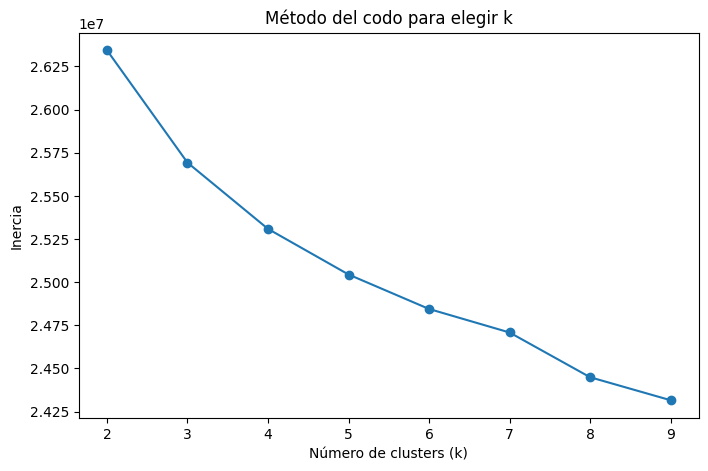

In [26]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 10)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_scaled)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(8, 5))
plt.plot(K, inertia, marker='o')
plt.xlabel("Número de clusters (k)")
plt.ylabel("Inercia")
plt.title("Método del codo para elegir k")
plt.show()


Paso 4: Elegir k y aplicar clustering

In [27]:
kmeans = KMeans(n_clusters=5, random_state=42)
df['cluster'] = kmeans.fit_predict(X_scaled)


Paso 5: Análisis del resultado


In [28]:
# Ver distribución de usuarios por cluster
print(df['cluster'].value_counts())

# Ver características medias por cluster
cluster_summary = df.drop(columns='user_id').groupby('cluster').mean()
print(cluster_summary)


cluster
4    71554
2    51723
1    47601
3    18206
0    17125
Name: count, dtype: int64
         n_pedidos  dias_medios_entre_pedidos  total_productos_comprados  \
cluster                                                                    
0        23.095416                  12.960633                 230.528934   
1        20.057814                  13.754364                 211.605197   
2         9.950100                  17.925053                  38.528488   
3        45.506481                   8.584533                 603.727837   
4        10.169411                  17.127740                  75.883724   

         porcentaje_reordenados  productos_por_pedido         1         2  \
cluster                                                                     
0                      0.469904             12.019254  0.103650  0.156847   
1                      0.489440             13.190127  0.141321  0.242852   
2                      0.400942              4.671282  0.033892  0.026

In [29]:
df.groupby('cluster').mean()[['n_pedidos', 'dias_medios_entre_pedidos',
                              'total_productos_comprados', 'porcentaje_reordenados',
                              'productos_por_pedido']]

,n_pedidos,dias_medios_entre_pedidos,total_productos_comprados,porcentaje_reordenados,productos_por_pedido
cluster,,,,,
0,23.095416,12.960633,230.528934,0.469904,12.019254
1,20.057814,13.754364,211.605197,0.489440,13.190127
2,9.950100,17.925053,38.528488,0.400942,4.671282
3,45.506481,8.584533,603.727837,0.635135,15.208959
4,10.169411,17.127740,75.883724,0.356200,9.781516


Paso 6: Visualización 2D con PCA

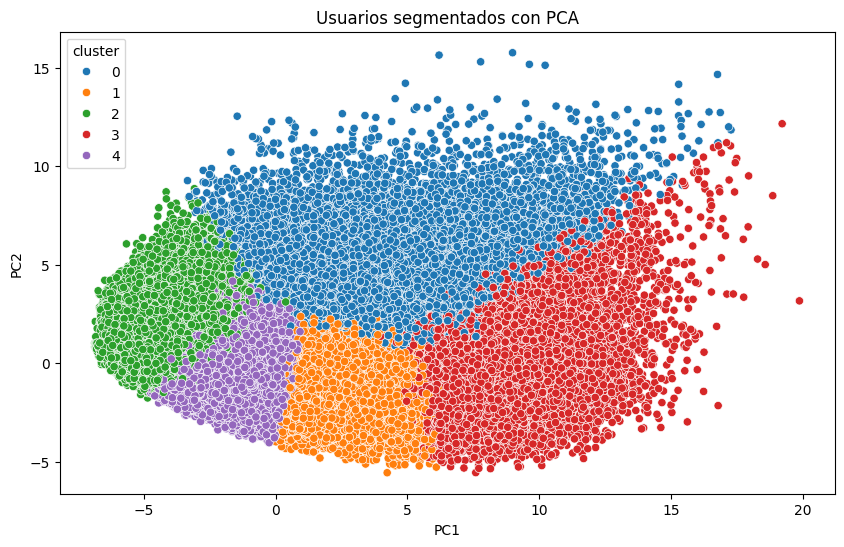

In [30]:
from sklearn.decomposition import PCA
import seaborn as sns

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = df['cluster']

plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', palette='tab10')
plt.title("Usuarios segmentados con PCA")
plt.show()


Vamos a hacer subclusters dentro de los clusters para una recomendación mucho más personalizada

In [31]:

cluster_0 = df[df['cluster'] == 0].copy()
X0 = X_scaled[df['cluster'] == 0]  # Subconjunto escalado


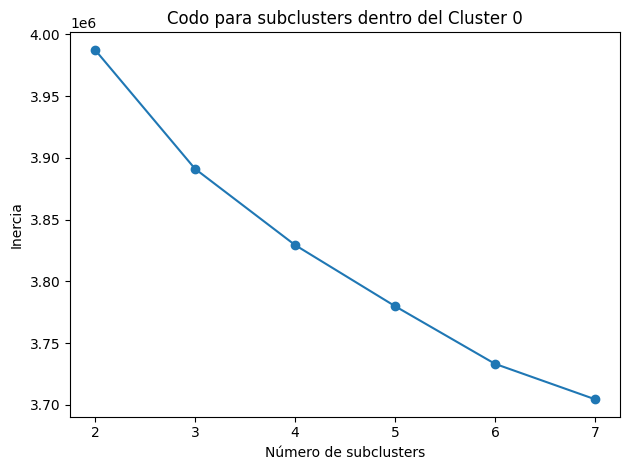

In [32]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertia = []
K = range(2, 8)

for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X0)
    inertia.append(km.inertia_)

plt.plot(K, inertia, marker='o')
plt.title("Codo para subclusters dentro del Cluster 0")
plt.xlabel("Número de subclusters")
plt.ylabel("Inercia")
plt.tight_layout()
plt.show()


In [33]:
subkmeans = KMeans(n_clusters=3, random_state=42)
cluster_0['subcluster'] = subkmeans.fit_predict(X0)


In [34]:
cluster_0.groupby('subcluster').mean()[['n_pedidos', 'porcentaje_reordenados', 'productos_por_pedido']]


,n_pedidos,porcentaje_reordenados,productos_por_pedido
subcluster,,,
0,25.264168,0.466805,11.439397
1,19.718744,0.455569,11.951704
2,30.724556,0.514044,12.767178


In [35]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

def metodo_del_codo_por_cluster(df, cluster_id, max_k=8):
    print(f"📊 Cluster {cluster_id}")
    
    subset = df[df['cluster'] == cluster_id].copy()
    features = subset.drop(columns=['user_id', 'cluster', 'subcluster'])
    
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    inertia = []
    K = range(2, max_k+1)
    for k in K:
        kmeans = KMeans(n_clusters=k, random_state=42)
        kmeans.fit(features_scaled)
        inertia.append(kmeans.inertia_)

    plt.figure(figsize=(7, 4))
    plt.plot(K, inertia, marker='o')
    plt.title(f"Método del codo para Cluster {cluster_id}")
    plt.xlabel("Número de subclusters")
    plt.ylabel("Inercia")
    plt.tight_layout()
    plt.show()



In [ ]:
# for c in sorted(df['cluster'].unique()):
#     metodo_del_codo_por_cluster(df, cluster_id=c)


In [36]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Crear la columna subcluster inicial
df['subcluster'] = -1

# Subclusters por cluster principal
subclusters_por_cluster = {
    0: 3,
    1: 1,
    2: 2,
    3: 2,
    4: 2
}

# Aplicar subclustering personalizado a cada cluster
for cluster_id, k_sub in subclusters_por_cluster.items():
    print(f"🔍 Aplicando subclustering para Cluster {cluster_id} con {k_sub} subclusters")

    # Filtrar usuarios del cluster actual
    subset = df[df['cluster'] == cluster_id].copy()
    features = subset.drop(columns=['user_id', 'cluster', 'subcluster'])

    # Escalado
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Subclustering
    subkmeans = KMeans(n_clusters=k_sub, random_state=42)
    subclusters = subkmeans.fit_predict(features_scaled)

    # Asignar subclusters
    df.loc[subset.index, 'subcluster'] = subclusters

print("✅ Subclustering final aplicado.")


🔍 Aplicando subclustering para Cluster 0 con 3 subclusters
🔍 Aplicando subclustering para Cluster 1 con 1 subclusters
🔍 Aplicando subclustering para Cluster 2 con 2 subclusters
🔍 Aplicando subclustering para Cluster 3 con 2 subclusters
🔍 Aplicando subclustering para Cluster 4 con 2 subclusters
✅ Subclustering final aplicado.


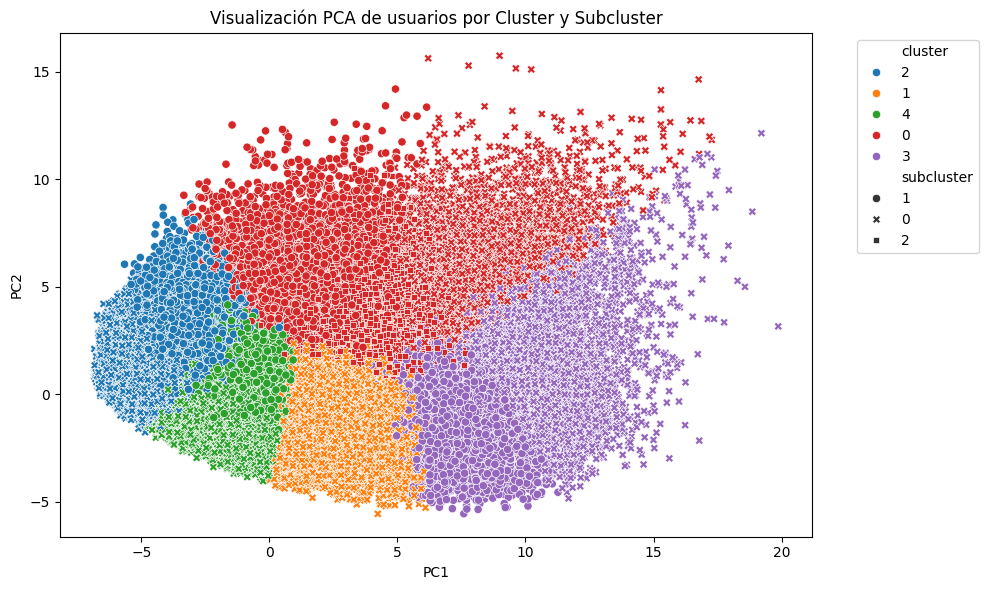

In [37]:
from sklearn.decomposition import PCA
import seaborn as sns
import matplotlib.pyplot as plt

# Usamos todas las variables numéricas excepto user_id, cluster y subcluster
features = df.drop(columns=['user_id', 'cluster', 'subcluster'])

# Escalamos
scaler = StandardScaler()
X_scaled = scaler.fit_transform(features)

# PCA a 2 dimensiones
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# Construimos DataFrame para visualización
pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['cluster'] = df['cluster'].astype(str)
pca_df['subcluster'] = df['subcluster'].astype(str)

# Visualizamos
plt.figure(figsize=(10, 6))
sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='cluster', style='subcluster', palette='tab10')
plt.title("Visualización PCA de usuarios por Cluster y Subcluster")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [38]:
df.groupby(['cluster', 'subcluster']).size()


cluster  subcluster
0        0              3669
         1              6265
         2              7191
1        0             47601
2        0             36392
         1             15331
3        0              5315
         1             12891
4        0             46102
         1             25452
dtype: int64

In [39]:
df.groupby(['cluster', 'subcluster'])[['n_pedidos', 'porcentaje_reordenados', 'productos_por_pedido']].mean()


n_pedidos  porcentaje_reordenados  productos_por_pedido
cluster subcluster                                                         
0       0           37.145816                0.569393             13.896343
        1           21.919553                0.464327              9.399172
        2           16.951050                0.424000             13.344212
1       0           20.057814                0.489440             13.190127
2       0            8.081529                0.390579              3.966956
        1           14.385624                0.425542              6.343177
3       0           53.282032                0.645379             16.690375
        1           42.300597                0.630912             14.598166
4       0            7.776018                0.309767              9.819805
        1           14.504636                0.440306              9.712163

In [40]:
def recomendar_productos(user_id, n=5):
    # Obtener cluster y subcluster del usuario
    if user_id not in df['user_id'].values:
        print("❌ Usuario no encontrado.")
        return []

    c = df.loc[df['user_id'] == user_id, 'cluster'].values[0]
    s = df.loc[df['user_id'] == user_id, 'subcluster'].values[0]

    # Filtrar usuarios en el mismo cluster + subcluster
    usuarios_similares = df[(df['cluster'] == c) & (df['subcluster'] == s)]['user_id'].values

    # Filtrar compras de estos usuarios
    compras_similares = productos[productos['user_id'].isin(usuarios_similares)]

    # Contar productos más populares
    productos_populares = compras_similares['product_id'].value_counts()

    # Productos que ya ha comprado el usuario
    productos_usuario = productos[productos['user_id'] == user_id]['product_id'].unique()

    # Eliminar los que ya ha comprado
    productos_recomendados = productos_populares[~productos_populares.index.isin(productos_usuario)].head(n)

    # Añadir nombres de producto
    recomendados = products[products['product_id'].isin(productos_recomendados.index)][['product_id', 'product_name']]
    recomendados['veces_comprado_en_grupo'] = recomendados['product_id'].map(productos_recomendados)

    # Ordenar por frecuencia
    recomendados = recomendados.sort_values(by='veces_comprado_en_grupo', ascending=False).reset_index(drop=True)

    return recomendados


In [41]:
recomendar_productos(user_id=6, n=5)


,product_id,product_name,veces_comprado_en_grupo
0,13176,Bag of Organic Bananas,21882
1,24852,Banana,11391
2,43352,Raspberries,10564
3,16797,Strawberries,10463
4,12341,Hass Avocados,10160


In [42]:
# Crear un DataFrame con solo user_id, cluster y subcluster
clusters_resumen = df[['user_id', 'cluster', 'subcluster']]

# Guardarlo como CSV
clusters_resumen.to_csv("usuarios_clusters.csv", index=False)

# Mostrar confirmación
clusters_resumen.head()


,user_id,cluster,subcluster
0,1,2,1
1,2,1,0
2,3,4,1
3,4,2,1
4,5,4,0


In [43]:
# Seleccionar 5 usuarios aleatorios por cluster + subcluster
usuarios_muestra = (
    df.groupby(['cluster', 'subcluster'])
    .apply(lambda x: x.sample(n=5, random_state=42) if len(x) >= 5 else x)
    .reset_index(drop=True)
)

# Ver el resultado
print("👥 Usuarios seleccionados por cluster + subcluster:")
print(usuarios_muestra[['user_id', 'cluster', 'subcluster']])

# (Opcional) Guardar en CSV para revisar luego
usuarios_muestra[['user_id', 'cluster', 'subcluster']].to_csv("usuarios_muestra.csv", index=False)


👥 Usuarios seleccionados por cluster + subcluster:
    user_id  cluster  subcluster
0     10341        0           0
1    150518        0           0
2    175457        0           0
3     58540        0           0
4     60259        0           0
5    185755        0           1
6     75998        0           1
7    154084        0           1
8    127229        0           1
9    189733        0           1
10   116226        0           2
11   109125        0           2
12   145744        0           2
13   124764        0           2
14    47326        0           2
15   139468        1           0
16    74373        1           0
17   134577        1           0
18   176768        1           0
19    50290        1           0
20   171372        2           0
21   139168        2           0
22   145384        2           0
23    12649        2           0
24    63366        2           0
25   111003        2           1
26    99094        2           1
27   198896        2     

/tmp/ipykernel_21712/2936587920.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  .apply(lambda x: x.sample(n=5, random_state=42) if len(x) >= 5 else x)


In [ ]:
recomendar_productos(user_id=104105, n=5)



,product_id,product_name,veces_comprado_en_grupo
0,21137,Organic Strawberries,20156
1,16797,Strawberries,16788
2,47209,Organic Hass Avocado,15687
3,47766,Organic Avocado,11842
4,39275,Organic Blueberries,11453


In [44]:
grupo = df[(df['cluster'] == 0) & (df['subcluster'] == 1)]
usuarios_grupo = grupo['user_id'].unique()
compras_grupo = productos[productos['user_id'].isin(usuarios_grupo)]


In [45]:
print(df)

        user_id  n_pedidos  dias_medios_entre_pedidos  \
0             1         11                  19.000000   
1             2         15                  16.285714   
2             3         13                  12.000000   
3             4          6                  17.000000   
4             5          5                  11.500000   
...         ...        ...                        ...   
206204   206205          4                  16.666667   
206205   206206         68                   3.716418   
206206   206207         17                  14.312500   
206207   206208         50                   7.367347   
206208   206209         14                  18.461538   

        total_productos_comprados  porcentaje_reordenados  \
0                              59                0.694915   
1                             195                0.476923   
2                              88                0.625000   
3                              18                0.055556   
4         

In [46]:
from surprise import Dataset, Reader, SVD

print("Todo OK con Surprise 🎉")


Todo OK con Surprise 🎉


In [47]:
from surprise import Dataset, Reader
from surprise import SVD

# Creamos el dataset
compras_binarias = compras_grupo[['user_id', 'product_id']].copy()
compras_binarias['comprado'] = 1

reader = Reader(rating_scale=(0, 1))
data = Dataset.load_from_df(compras_binarias[['user_id', 'product_id', 'comprado']], reader)
trainset = data.build_full_trainset()
